In [1]:
import numpy as np

from tqdm import tqdm

from astropy import units as u
from astropy import constants as const
from astropy.io import ascii
from astropy.table import Table

from synphot import SourceSpectrum, ReddeningLaw
from synphot.models import BlackBodyNorm1D
from synphot.units import convert_flux

import stam

import matplotlib.pyplot as plt

%matplotlib tk

plt.style.use('Nature')

from IPython.display import Image

In [2]:
# Nature standards: https://www.nature.com/nature/for-authors/final-submission
figwidth_single = 89/25.4  # [inch]
figwidth_double = 183/25.4  # [inch]

# Auxiliary functions

In [3]:
def blackbody(temperature, wavelength, ebv=None, extinction_model='mwavg'):
    bb = SourceSpectrum(BlackBodyNorm1D, temperature=temperature*u.K)  # [photons s^-1 cm^-2 A^-1]
    if ebv is not None:
        # apply extinction
        ext = ReddeningLaw.from_extinction_model(extinction_model).extinction_curve(ebv)
        bb = bb * ext
    bb = bb(wavelength)/(const.R_sun / const.kpc) ** 2  # undo synphot normalization (but leave the pi factor from integration over half a sphere)
    bb = convert_flux(wavelength, bb, 'flam')  # [flam] = [erg s^-1 cm^-2 A^-1]
    bb = bb.to(u.erg/u.s/u.cm**2/u.angstrom)  # express in normal astropy units
    return bb


def mlogg2radius(m, logg):
    g = 10**logg*u.cm/u.s**2
    r = np.sqrt(const.G*m/g)
    return r.to(u.Rsun).value


def calc_synth_phot(wavelength, flux, bandpass):
    dlambda = np.diff(wavelength)
    dlambda = np.concatenate([dlambda, np.array([dlambda[-1]])])

    # assuming a photon-counting device
    phot = np.sum(dlambda*bandpass*wavelength*flux)/np.sum(dlambda*bandpass*wavelength)
    
    return phot


amrf = lambda q, S : q/(1+q)**(2/3)*(1 - S*(1+q)/(q*(1+S)))

# Read data

## Gaia passbands

In [4]:
gaia_passband = ascii.read('../data/other/passband.dat', names=["wl", "gPb", "gPbError", "bpPb", "bpPbError", "rpPb", "rpPbError"])

# replace missing values with NaNs
for col in gaia_passband.itercols():
    col[col == 99.99] = 0
    
gaia_passband['wl'] *= 10  # [A]

## Evolutionary tracks

### PARSEC models

In [5]:
parsec_models = stam.getmodels.read_parsec(path='../data/PARSEC v1.2S/Gaia DR3/', config_file=None)

Taking PARSEC files from ../data/PARSEC v1.2S/Gaia DR3/


## Binaries in clusters

In [6]:
data = Table.read('../table_hst.fits')
idxs = ((data['nss_solution_type'] == 'Orbital') | (data['nss_solution_type'] == 'AstroSpectroSB1'))
sources = data[idxs]

# Initial check

In [7]:
i = 0
log_age = sources['log_age_50'][i]
log_age_res = 0.025  # [dex]
mh = np.round(np.max([np.min([sources['mh_for_mass_interp'][i], 0.6]), -2]), 1)  # [M/H] round to the nearest available track  # [M/H]
stage_min = 0  # pre-main sequence
stage_max = 3  # red giant branch
mass_min = 0  # [Msun]
mass_max = 8  # [Msun]

In [8]:
track_idx = stam.gentracks.get_isotrack(parsec_models, [log_age, mh], params=("log_age", "mh"),
                                     log_age_res=log_age_res, mass_min=mass_min, mass_max=mass_max,
                                     stage=None, stage_min=stage_min, stage_max=stage_max, sort_by="age", return_idx=True)[-1]

tracks = parsec_models[track_idx].copy()
tracks.sort('Mini')

# Run

In [8]:
sources['Ams'] = np.full(len(sources),np.nan)
sources['Atr'] = np.full(len(sources),np.nan)

In [11]:
## calculating for one source

stage_min = 0  # pre-main sequence
stage_max = 3  # red giant branch
mass_min = 0  # [Msun]
mass_max = 8  # [Msun]
log_age_res = 0.025  # [dex]

m2_vec = np.arange(0.1, 10, 0.1)

wavelength = gaia_passband['wl'].value  # [A]

Gflux1 = np.zeros(len(sources))
Gflux2 = np.zeros((len(sources), len(m2_vec)))
q = np.zeros((len(sources), len(m2_vec)))

i = 244

log_age = sources['log_age_50'][i]
mh = np.round(np.max([np.min([sources['mh_for_mass_interp'][i], 0.6]), -2]), 1)  # [M/H] round to the nearest available track  # [M/H]
m1 = sources['m1'][i]
try:
    track_idx = stam.gentracks.get_isotrack(parsec_models, [log_age, mh], params=("log_age", "mh"),
                                    log_age_res=log_age_res, mass_min=mass_min, mass_max=mass_max,
                                    stage=None, stage_min=stage_min, stage_max=stage_max, sort_by="age", return_idx=True)[-1]
    tracks = parsec_models[track_idx].copy()
    tracks.sort('Mini')
    ebv = sources['av_for_mass_interp'][i]/3.1
    idx = np.argmin(np.abs(tracks['Mass'] - m1))

    teff1 = 10**tracks['logTe'][idx]  # [K]
    logg1 = tracks['logg'][idx]
    r1 = mlogg2radius(m1*u.Msun, logg1)  # [Rsun]
    flux1 = blackbody(teff1, wavelength, ebv=ebv)*4*np.pi*r1**2
    Gflux1[i] = calc_synth_phot(wavelength, flux1, gaia_passband['gPb'].value).value

    q[i, :] = m2_vec/m1  # mass ratio

    for j in range(len(m2_vec)):
        m2 = m2_vec[j]
        idx = np.argmin(np.abs(tracks['Mass'] - m2))
        teff2 = 10**tracks['logTe'][idx]  # [K]
        logg2 = tracks['logg'][idx]
        r2 = mlogg2radius(m2*u.Msun, logg2)  # [Rsun]
        flux2 = blackbody(teff2, wavelength, ebv=ebv)*4*np.pi*r2**2
        Gflux2[i,j] = calc_synth_phot(wavelength, flux2, gaia_passband['gPb'].value).value

    ebv = sources['av_for_mass_interp'][i]/3.1
    Sms = Gflux2[i,:]/Gflux1[i]
    Ams = amrf(q[i, :], Sms)
    valid_idx = Sms < 1
    Ams = np.max(Ams[valid_idx]) 
    print(f'Ams = {Ams}')
    Str = 2*Gflux2[i,:]/Gflux1[i]
    Atr = amrf(2*q[i, :], Str)
    valid_idx = Str < 1
    Atr = np.max(Atr[valid_idx])
    print(f'Atr = {Atr}')
except:
    print(f'i = {i}')

Ams = 0.22024396878741948
Atr = 0.34652635723261893


In [10]:
## calculating for all sources

stage_min = 0  # pre-main sequence
stage_max = 3  # red giant branch
mass_min = 0  # [Msun]
mass_max = 8  # [Msun]
log_age_res = 0.025  # [dex]

m2_vec = np.arange(0.1, 10, 0.1)

wavelength = gaia_passband['wl'].value  # [A]

Gflux1 = np.zeros(len(sources))
Gflux2 = np.zeros((len(sources), len(m2_vec)))
q = np.zeros((len(sources), len(m2_vec)))


for i in tqdm(range(len(sources))):
    log_age = sources['log_age_50'][i]
    mh = np.round(np.max([np.min([sources['mh_for_mass_interp'][i], 0.6]), -2]), 1)  # [M/H] round to the nearest available track  # [M/H]
    m1 = sources['m1'][i]
    if np.isnan(mh):
        mh = np.round(np.max([np.min([sources['mh_xgboost_cluster_median'][i], 0.6]), -2]), 1)
        m1 = sources['parsec_m1_*'][i]
    try:
        track_idx = stam.gentracks.get_isotrack(parsec_models, [log_age, mh], params=("log_age", "mh"),
                                        log_age_res=log_age_res, mass_min=mass_min, mass_max=mass_max,
                                        stage=None, stage_min=stage_min, stage_max=stage_max, sort_by="age", return_idx=True)[-1]
        tracks = parsec_models[track_idx].copy()
        tracks.sort('Mini')
        ebv = sources['av_for_mass_interp'][i]/3.1
        idx = np.argmin(np.abs(tracks['Mass'] - m1))

        teff1 = 10**tracks['logTe'][idx]  # [K]
        logg1 = tracks['logg'][idx]
        r1 = mlogg2radius(m1*u.Msun, logg1)  # [Rsun]
        flux1 = blackbody(teff1, wavelength, ebv=ebv)*4*np.pi*r1**2
        Gflux1[i] = calc_synth_phot(wavelength, flux1, gaia_passband['gPb'].value).value

        q[i, :] = m2_vec/m1  # mass ratio

        for j in range(len(m2_vec)):
            m2 = m2_vec[j]
            idx = np.argmin(np.abs(tracks['Mass'] - m2))
            teff2 = 10**tracks['logTe'][idx]  # [K]
            logg2 = tracks['logg'][idx]
            r2 = mlogg2radius(m2*u.Msun, logg2)  # [Rsun]
            flux2 = blackbody(teff2, wavelength, ebv=ebv)*4*np.pi*r2**2
            Gflux2[i,j] = calc_synth_phot(wavelength, flux2, gaia_passband['gPb'].value).value

        ebv = sources['av_for_mass_interp'][i]/3.1
        Sms = Gflux2[i,:]/Gflux1[i]
        Ams = amrf(q[i, :], Sms)
        valid_idx = Sms < 1
        Ams = np.max(Ams[valid_idx]) 
        sources['Ams'][i] = Ams
        Str = 2*Gflux2[i,:]/Gflux1[i]
        Atr = amrf(2*q[i, :], Str)
        valid_idx = Str < 1
        Atr = np.max(Atr[valid_idx])
        sources['Atr'][i] = Atr
    except:
        print(f'i = {i}')

  0%|          | 0/6 [00:00<?, ?it/s]

100%|██████████| 6/6 [00:16<00:00,  2.76s/it]


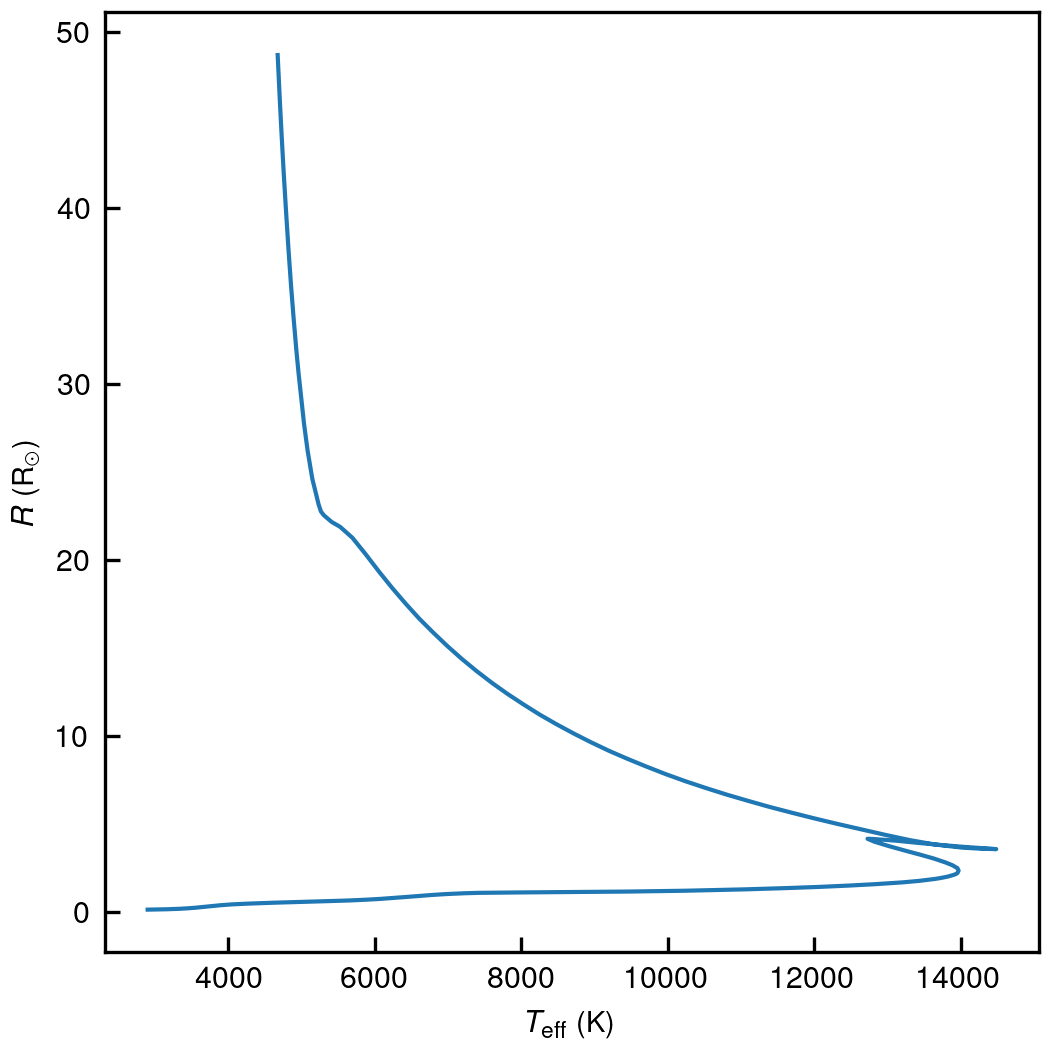

In [125]:
filename = './img/EvolutionaryTrack'

fig, ax  = plt.subplots(figsize=(figwidth_single, figwidth_single), constrained_layout=True)

# ii = tracks['label'] == 1

ax.plot(10**tracks['logTe'], mlogg2radius(tracks['Mini'].value*u.Msun, tracks['logg']))
# ax.plot(10**tracks['logTe'][ii], mlogg2radius(tracks['Mini'][ii].value*u.Msun, tracks['logg'][ii]),'.')

ax.set_xlabel(r'$T_\text{eff}$ (K)')
ax.set_ylabel(r'$R$ (R$_\odot$)')

# ii = tracks['label'] == 1

# ax.plot(tracks['Mass'], mlogg2radius(tracks['Mass'].value*u.Msun, tracks['logg']))
# ax.set_xlabel(r'$M$ (M$_\odot$)')
# ax.set_ylabel(r'$R$ (R$_\odot$)')


# # ax.plot(tracks['G_BPmag'] - tracks['G_RPmag'], tracks['Gmag'])
# ax.scatter(tracks['G_BPmag'] - tracks['G_RPmag'], tracks['Gmag'], s=3, c=tracks['label'])
# ax.set_xlabel(r'$G_\text{BP}-G_\text{RP}$')
# ax.set_ylabel(r'$G_\text{abs}$')
# ax.invert_yaxis()


fig.savefig(filename+".png", dpi=300)
# fig.savefig(filename+".pdf", dpi=300)
Image(filename+".png")

## Class-I limit (MS companion)

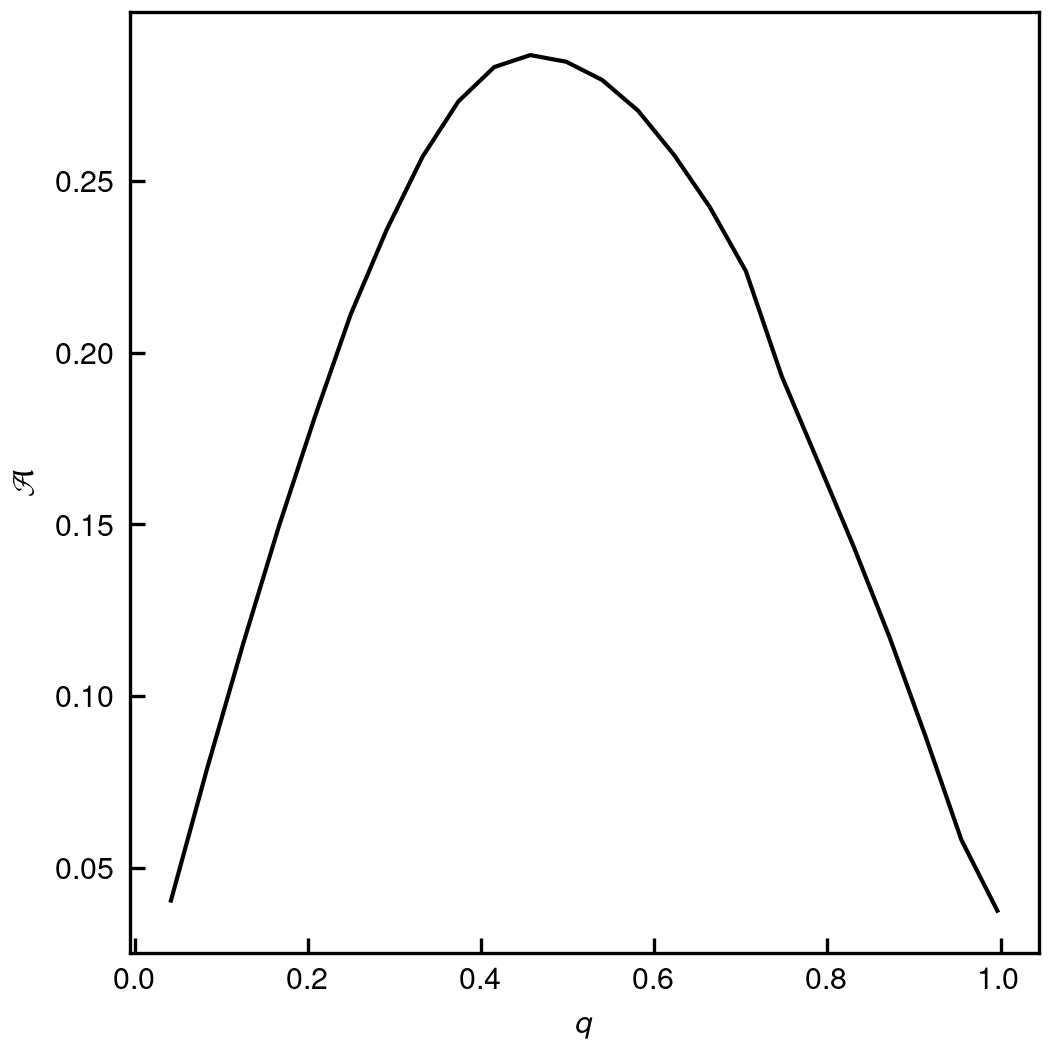

In [122]:
filename = "./img/AMRF_limits_binary"

fig, ax  = plt.subplots(figsize=(figwidth_single, figwidth_single), constrained_layout=True)

colors = plt.cm.Greys_r(np.linspace(0, 0.75, len(sources)))

# for i in range(len(sources)):
ebv = sources['a_v_50'][i]/3.1
S = Gflux2[i,:]/Gflux1[i]
A = amrf(q[i, :], S)
valid_idx = S < 1
ax.plot(q[i, valid_idx], A[valid_idx], c=colors[i])

ax.set_xlabel(r'$q$')
ax.set_ylabel(r'$\mathcal{A}$')
# ax.legend(loc='upper right')

fig.savefig(filename+".png", dpi=300)
# fig.savefig(filename+".pdf", dpi=300)
Image(filename+".png")

## Class-II limit (MS+MS binary companion)

Assuming equal-mass binary companion

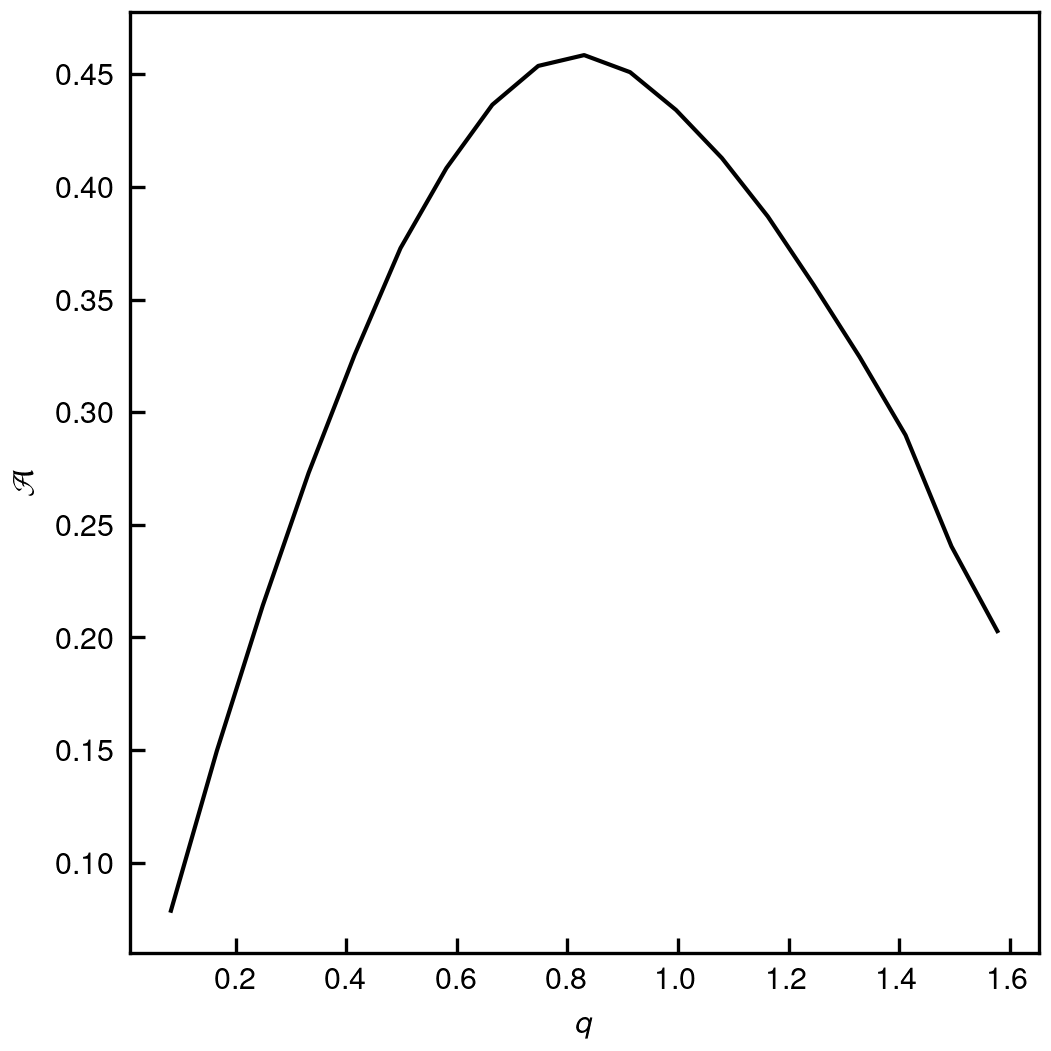

In [123]:
filename = "./img/AMRF_limit_triple"

fig, ax  = plt.subplots(figsize=(figwidth_single, figwidth_single), constrained_layout=True)

colors = plt.cm.Greys_r(np.linspace(0, 0.75, len(sources)))

# for i in range(len(sources)):
ebv = sources['a_v_50'][i]/3.1
S = 2*Gflux2[i,:]/Gflux1[i]
A = amrf(2*q[i, :], S)
valid_idx = S < 1
ax.plot(q[i, valid_idx]*2, A[valid_idx], c=colors[i])

ax.set_xlabel(r'$q$')
ax.set_ylabel(r'$\mathcal{A}$')
# ax.legend(loc='upper right')

fig.savefig(filename+".png", dpi=300)
# fig.savefig(filename+".pdf", dpi=300)
Image(filename+".png")

## Combined

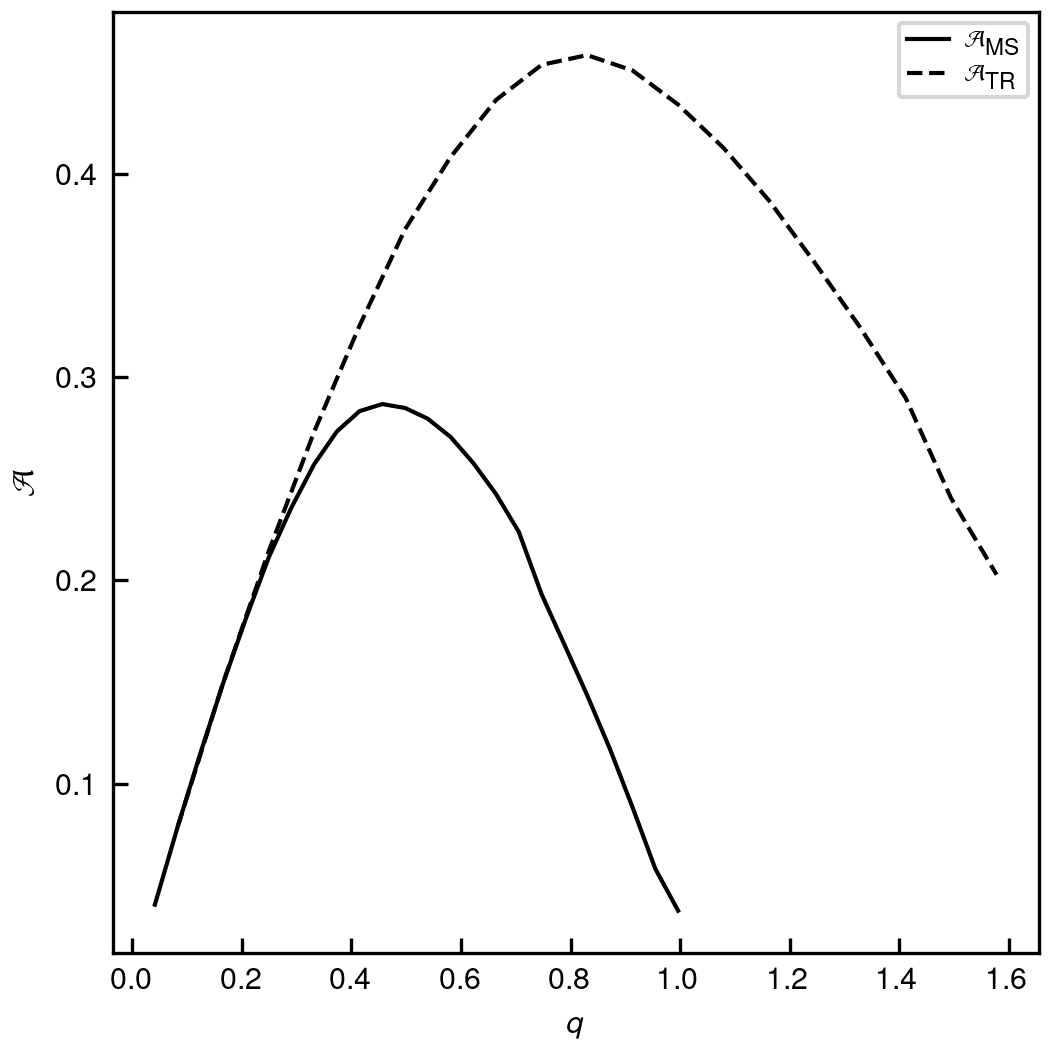

In [124]:
filename = "./img/AMRF_limits"

fig, ax  = plt.subplots(figsize=(figwidth_single, figwidth_single), constrained_layout=True)

colors = plt.cm.Greys_r(np.linspace(0, 0.75, len(sources)))

# for i in range(len(sources)):
ebv = sources['a_v_50'][i]/3.1
S = Gflux2[i,:]/Gflux1[i]
A = amrf(q[i, :], S)
valid_idx = S < 1
ax.plot(q[i, valid_idx], A[valid_idx], c=colors[i], label=r"$\mathcal{A}_\text{MS}$")

S = 2*Gflux2[i,:]/Gflux1[i]
A = amrf(2*q[i, :], S)
valid_idx = S < 1
ax.plot(q[i, valid_idx]*2, A[valid_idx], "--", c=colors[i], label=r"$\mathcal{A}_\text{TR}$")

ax.set_xlabel(r'$q$')
ax.set_ylabel(r'$\mathcal{A}$')
ax.legend(loc='upper right')

fig.savefig(filename+".png", dpi=300)
# fig.savefig(filename+".pdf", dpi=300)
Image(filename+".png")